# Turbo codes BER/FER simulation

This notebook shows how to build a turbo encoder and decoder.

## Objectives

At the end of this notebook, you should be able to :
* Build and bind a turbo encoder
* Build and bind a turbo decoder

## Import librairies

In [7]:
#!/usr/bin/env python3

import sys
sys.path.insert(0, '../../build/lib')

import numpy as np
import py_aff3ct as aff3ct
import math
import time
import matplotlib.pyplot as plt
from datetime import timedelta

## Set simulation parameters

In [8]:
K = 204*2
N = 3*K
ebn0_min = 0
ebn0_max = 1.4
ebn0_step = 0.2

ebn0 = np.arange(ebn0_min,ebn0_max,ebn0_step)
esn0 = ebn0 + 10 * math.log10(K/N)
sigma_vals = 1/(math.sqrt(2) * 10 ** (esn0 / 20))

## Build the modules

Building and turbo coding scheme requires several component `modules`.

The encoder requires :
* 2 convolutionnal encoders (natural and interleaved orders)
* 1 bit interleaver

The decoder requires :
* 2 component SISO decoders (BCJR)
* 1 llr interleaver

Nb : Each component SISO decoder requires a trellis generated by the encoders

The use of parenthesis for accessing tasks is deprecated, use brackets instead.
The use of parenthesis for accessing tasks is deprecated, use brackets instead.
 Eb/NO (dB) | Frame number |    BER   |    FER   |  Tpt (Mbps)
------------|--------------|----------|----------|------------
       0.00 |         1157 | 2.11e-01 | 8.69e-01 |       6.30
       0.20 |         1222 | 1.82e-01 | 8.23e-01 |       6.18
       0.40 |         1672 | 1.25e-01 | 6.00e-01 |       5.03
       0.60 |         2546 | 7.66e-02 | 3.95e-01 |       4.59
       0.80 |         4501 | 4.12e-02 | 2.23e-01 |       5.07
       1.00 |        12316 | 1.31e-02 | 8.13e-02 |       5.72
       1.20 |        33538 | 4.21e-03 | 2.98e-02 |       5.76


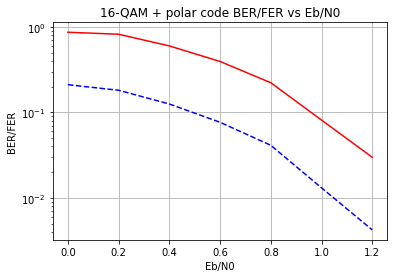

# (II) Statistics are unavailable. Did you enable the statistics in the tasks?


In [9]:

src = aff3ct.module.source.Source_random_fast(K, 12)

# Build two rate-1/2 convolutionnal encoders.
enc_n = aff3ct.module.encoder.Encoder_RSC_DB(K,2*K,standard='DVB-RCS2')
enc_i = aff3ct.module.encoder.Encoder_RSC_DB(K,2*K,standard='DVB-RCS2')

# Build DVBS-RCS2 Interleaver.
itl_core = aff3ct.tools.interleaver_core.Interleaver_core_ARP_DVB_RCS2(K//2)
itl_bit  = aff3ct.module.interleaver.Interleaver_int32(itl_core)
itl_llr  = aff3ct.module.interleaver.Interleaver_float(itl_core)

# Build the turbo encoder
enc = aff3ct.module.encoder.Encoder_turbo_DB(K,N,enc_n,enc_i,itl_bit)

# Get the trellis
trellis_n = enc_n.get_trellis()
trellis_i = enc_i.get_trellis()

# Build the component SISO decoders
dec_n = aff3ct.module.decoder.Decoder_RSC_DB_BCJR_DVB_RCS2(K,trellis_n)
dec_i = aff3ct.module.decoder.Decoder_RSC_DB_BCJR_DVB_RCS2(K,trellis_i)

# Build the turbo decoder
dec   = aff3ct.module.decoder.Decoder_turbo_DB(K,N,8,dec_n,dec_i,itl_llr)

mdm   = aff3ct.module.modem.Modem_BPSK_fast(N)

gen = aff3ct.tools.Gaussian_noise_generator_implem.FAST
chn = aff3ct.module.channel.Channel_AWGN_LLR(N, gen)
mnt = aff3ct.module.monitor.Monitor_BFER_AR(K, 1000)

sigma = np.ndarray(shape = (1,1),  dtype = np.float32)
enc["encode       ::U_K "].bind(src["generate   ::U_K "])
mdm["modulate     ::X_N1"].bind(enc["encode     ::X_N "])
chn["add_noise    ::X_N "].bind(mdm["modulate   ::X_N2"])
mdm["demodulate   ::Y_N1"].bind(chn["add_noise  ::Y_N "])
dec["decode_siho  ::Y_N "].bind(mdm["demodulate ::Y_N2"])
mnt["check_errors ::U   "].bind(src["generate   ::U_K "])
mnt["check_errors ::V   "].bind(dec["decode_siho::V_K "])
chn["add_noise    ::CP  "].bind(                 sigma  )
mdm["demodulate   ::CP  "].bind(                 sigma  )

seq  = aff3ct.tools.sequence.Sequence(src("generate"), mnt("check_errors"), 8)

fer = np.zeros(len(ebn0))
ber = np.zeros(len(ebn0))

print(" Eb/NO (dB) | Frame number |    BER   |    FER   |  Tpt (Mbps)")
print("------------|--------------|----------|----------|------------")
for i in range(len(sigma_vals)):
	sigma[:] = sigma_vals[i]

	t = time.time()
	seq.exec()
	elapsed = time.time() - t
	total_fra = mnt.get_n_analyzed_fra()

	ber[i] = mnt.get_ber()
	fer[i] = mnt.get_fer()

	tpt = total_fra * K * 1e-6/elapsed
	print("%11.2f | %12d | %7.2e | %7.2e | %10.2f"%(ebn0[i], total_fra, ber[i], fer[i], tpt))

	mnt.reset()

fig = plt.figure()
plt.title("16-QAM + polar code BER/FER vs Eb/N0")
plt.xlabel("Eb/N0")
plt.ylabel("BER/FER")
plt.grid()
plt.semilogy(ebn0, fer, 'r-', ebn0, ber, 'b--')
plt.show()


## Exercise

Try to simulate another turbo coder/decoder.